# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импортировать библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузить данные 
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# предобработка данных: поделить значения яркости на 255
datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# извлечь данные из папки
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


In [5]:
# изучить данные: метод info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
# изучить данные: метод describe()
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
print('Размерность данных = ', labels.shape)

Размерность данных =  (7591, 2)


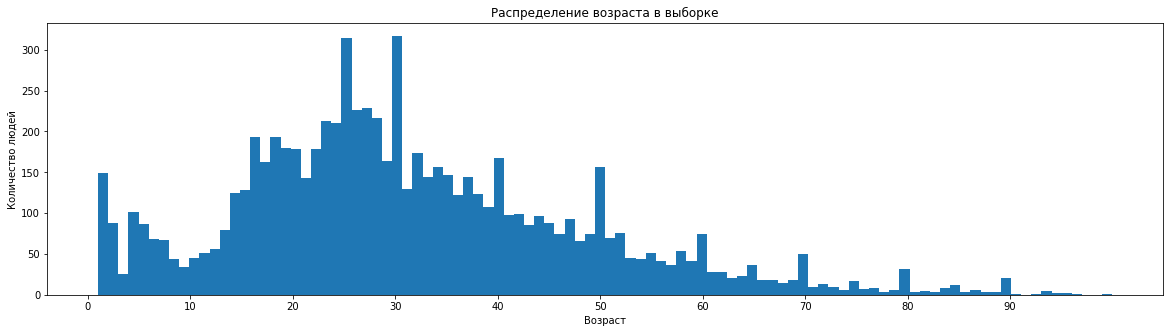

In [7]:
# построить гистограмму
plt.figure(figsize=(20, 5))
plt.hist(labels['real_age'], bins=100)
plt.xticks(np.arange(0, 100, step=10))
plt.title('Распределение возраста в выборке')
plt.gca().set(xlabel='Возраст', ylabel='Количество людей');

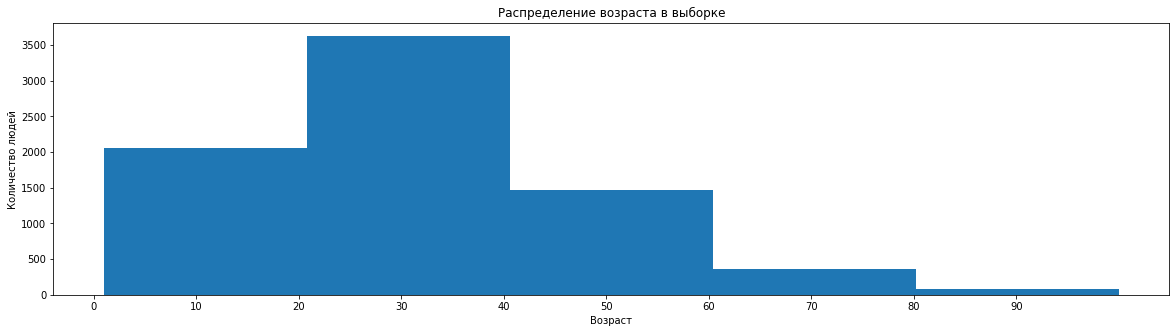

In [8]:
# построить гистограмму
plt.figure(figsize=(20, 5))
plt.hist(labels['real_age'], bins=5)
plt.xticks(np.arange(0, 100, step=10))
plt.title('Распределение возраста в выборке')
plt.gca().set(xlabel='Возраст', ylabel='Количество людей');

Можно отметить, что в выборке мало пожилых людей и детей, больше всего людей в возрасте от 20 до 40.

In [9]:
# распределение по возрастам
pivot_table = pd.pivot_table(labels,
                           index='real_age',
                           aggfunc='count').sort_values(by='file_name', ascending=False)
pivot_table.head()

,file_name
real_age,
30,317
25,315
27,229
26,226
28,217


In [10]:
# выделить целевой признак.
features, target = next(train_gen_flow)

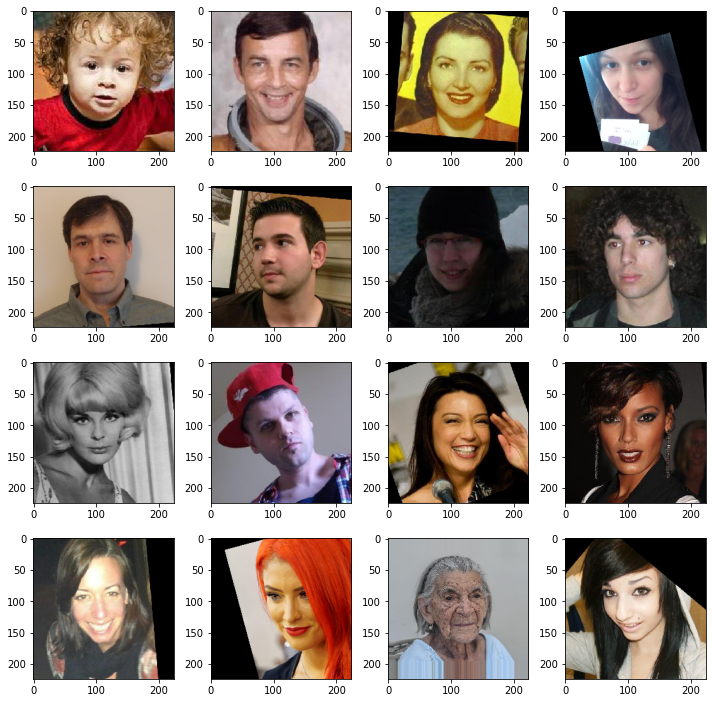

In [11]:
# вывести изображения
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()

Можно отметить, что в данных есть люди всех возрастов (ребёнок в первом ряду, пожилая женщина в 4 ряду). 
Также видим, что фотографии в выборке совершенно разные: ч/б, цветные, с плохим качеством, перевернутые.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=42)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=42)
    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-06-22 10:18:23.332184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-22 10:18:28.129186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 118s - loss: 199.3185 - mae: 11.1309 - val_loss: 609.4871 - val_mae: 20.2098
Epoch 2/5
356/356 - 41s - loss: 81.4901 - mae: 7.2576 - val_loss: 157.5388 - val_mae: 8.7140
Epoch 3/5
356/356 - 38s - loss: 35.1764 - mae: 5.8902 - val_loss: 83.4098 - val_mae: 6.6866
Epoch 4/5
356/356 - 39s - loss: 24.0833 - mae: 3.6614 - val_loss: 113.4730 - val_mae: 8.4667
Epoch 5/5
356/356 - 37s - loss: 19.0781 - mae: 3.3234 - val_loss: 62.2187 - val_mae: 6.2263
WARNING:tensorflow:sample_weight modes were coerced from
    
```

## Анализ обученной модели

Модель, которая была разработана, достигла необходимого порога точности, измеряемого метрикой MAE (Mean Absolute Error).

Модель успешно справляется с задачей проведения анализа покупок и предложения товаров, которые могут заинтересовать покупателей определенной возрастной группы, при достигнутой точности.

При достигнутой точности модели, точное решение задачи контроля добросовестности кассиров при продаже алкоголя невозможно, так как модель может допустить значительные ошибки в определении возраста детей и подростков.

Таким образом, модель успешно справляется с первой задачей, а вторая задача требует дополнительных решений для обеспечения точного контроля.